In [5]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline

In [6]:
# Import the Movies dataset
movies = pd.read_csv('Desktop/archive/movies_metadata.csv')
movies.head()

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [7]:
# Import the ratings dataset
ratings = pd.read_csv('Desktop/archive/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [8]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  26024289  ratings of  45466  movies.


In [10]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['id'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings
# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Comedy'], ['avg_romance_rating', 'avg_comedy_rating'])
print( "Number of records: ", len(genre_ratings))
genre_ratings.head()

Number of records:  251442


,avg_romance_rating,avg_comedy_rating
1,3.33,4.25
2,4.00,2.80
3,3.33,3.20
4,3.17,3.00
5,5.00,5.00


In [12]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_comedy_rating'] > score_limit_2)) | ((genre_ratings['avg_comedy_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    #biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = biased_dataset[:300]
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset
# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)
# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()
biased_dataset

Number of records:  300


,index,avg_romance_rating,avg_comedy_rating
0,2,4.00,2.80
1,4,3.17,3.00
2,8,3.00,2.56
3,9,2.75,3.88
4,11,3.43,3.16
...,...,...,...
295,1590,2.67,2.65
296,1594,3.50,2.50
297,1597,2.67,2.37
298,1598,4.00,3.00


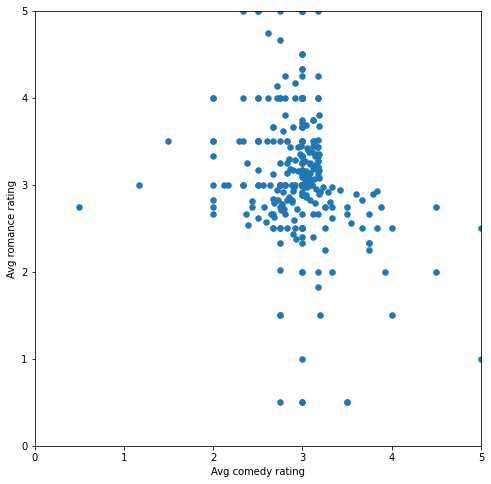

In [13]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)
# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_comedy_rating'],'Avg comedy rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

In [14]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_comedy_rating','avg_romance_rating']].values
# Import KMeans
from sklearn.cluster import KMeans
# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)
# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

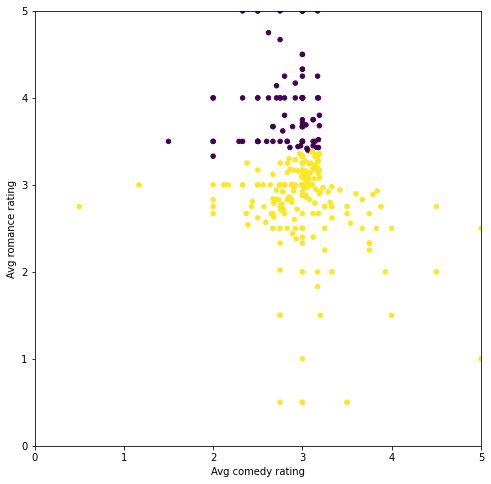

In [15]:
# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg comedy rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_comedy_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)
# Plot
draw_clusters(biased_dataset, predictions)

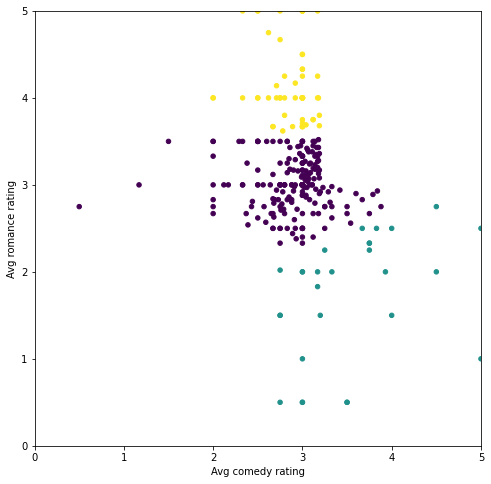

In [16]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

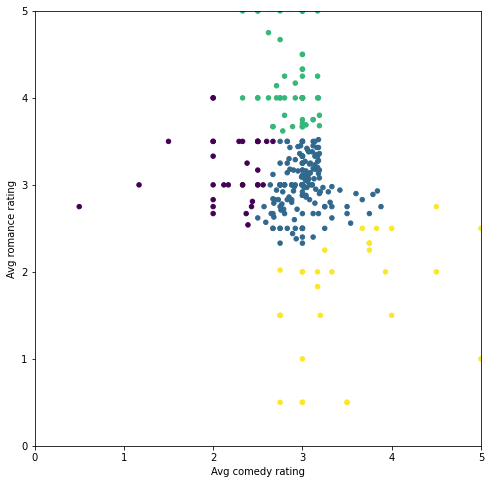

In [17]:
# Create an instance of KMeans to find three clusters
kmeans_3 = KMeans(n_clusters=4)
# Use fit_predict to cluster the dataset
predictions_3 = kmeans_3.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_3)

In [18]:
# Selecting our dataset to study
df = biased_dataset[['avg_comedy_rating','avg_romance_rating']]
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)
# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

<ipython-input-18-c6cd424f5601>:8: ConvergenceWarning: Number of distinct clusters (218) found smaller than n_clusters (222). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k).fit(data)
<ipython-input-18-c6cd424f5601>:8: ConvergenceWarning: Number of distinct clusters (218) found smaller than n_clusters (227). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k).fit(data)
<ipython-input-18-c6cd424f5601>:8: ConvergenceWarning: Number of distinct clusters (218) found smaller than n_clusters (232). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k).fit(data)
<ipython-input-18-c6cd424f5601>:8: ConvergenceWarning: Number of distinct clusters (218) found smaller than n_clusters (237). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k).fit(data)
<ipython-input-18-c6cd424f5601>:8: ConvergenceWarning: Number of distinct clusters (218) found smaller than n_clusters (242). Possibly due to duplicate points in X.
  kmean

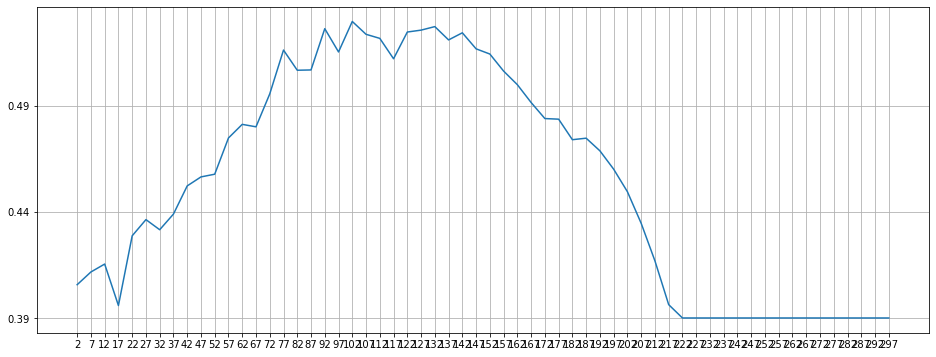

In [19]:
# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)
# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

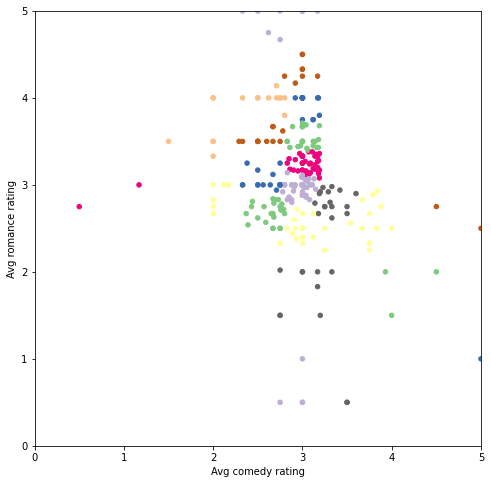

In [20]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=22)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

In [15]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Comedy', 'Action'],                                          
['avg_romance_rating', 'avg_comedy_rating', 'avg_action_rating'])
# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()
# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  266


,index,avg_romance_rating,avg_comedy_rating,avg_action_rating
0,2,4.00,2.80,3.75
1,4,3.17,3.00,3.50
2,8,3.00,2.56,3.15
3,9,2.75,3.88,4.62
4,11,3.43,3.16,3.32


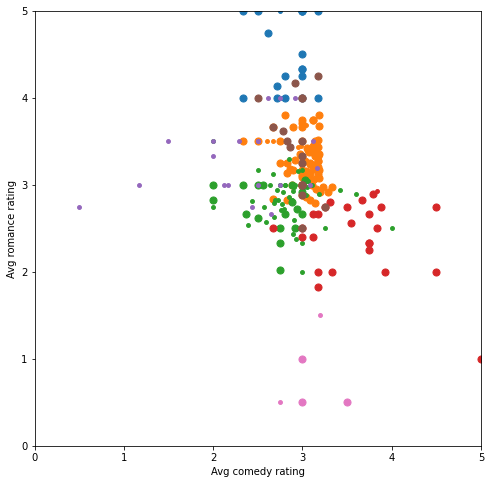

In [16]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_comedy_rating', 'avg_romance_rating', 'avg_action_rating']].values
# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)
# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg comedy rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
            color = next(colors)
            for index, point in clustered[clustered.group == g].iterrows():
                if point['avg_action_rating'] > 3: 
                    size = 50
                else:
                    size = 15
                plt.scatter(point['avg_comedy_rating'], 
                            point['avg_romance_rating'], 
                            s=size, 
                            color=color)
# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

In [6]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings.columns = ['userID','id','rating','timestamp']
#movies = movies.astype({"id": int})
#movies.insert(6, "movieId", int(movies['id']), True)
ratings = ratings.astype({"id": str})
ratings_title = pd.merge(ratings, movies[['id', 'title']], on='id' )
ratings_title.head()

,userID,id,rating,timestamp,title
0,1,110,1.0,1425941529,Three Colors: Red
1,11,110,3.5,1231676989,Three Colors: Red
2,22,110,5.0,1111937009,Three Colors: Red
3,24,110,5.0,979870012,Three Colors: Red
4,29,110,3.0,1044020005,Three Colors: Red


In [8]:
user_movie_ratings = pd.pivot_table(ratings_title, index='userID', columns= 'title', values='rating')
# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (265917, 7409) 

Subset example:


title,!Women Art Revolution,"$1,000 on the Black",$5 a Day,'Gator Bait,'R Xmas,'Twas the Night Before Christmas,(A)Sexual,...And God Created Woman,...And the Pursuit of Happiness,00 Schneider - Jagd auf Nihil Baxter
userID,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Define Function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1- Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2- Sort
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    # 3- Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    
    return most_rated_movies_users_selection

In [10]:
# Define the sorting by rating function
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

# choose the number of movies and users and sort
n_movies = 30
n_users = 18

most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings[1:500], n_movies, n_users)

# Print the result
print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()

dataset dimensions:  (18, 30)


title,The Million Dollar Hotel,Solaris,Terminator 3: Rise of the Machines,The 39 Steps,Monsoon Wedding,Once Were Warriors,License to Wed,Three Colors: Red,5 Card Stud,Sleepless in Seattle,...,Bridge to Terabithia,Shriek If You Know What I Did Last Friday the Thirteenth,Beauty and the Beast,Titanic,Batman Returns,The Hours,Dawn of the Dead,Rain Man,Confession of a Child of the Century,A Nightmare on Elm Street
386,5.0,5.0,5.0,5.0,5.0,4.5,5.0,4.5,4.5,3.5,...,4.0,5.0,4.0,3.00,5.0,4.0,4.50,3.0,5.0,4.0
363,5.0,4.0,4.5,3.5,4.0,3.5,5.0,4.5,3.5,4.0,...,3.5,4.5,2.0,3.25,4.5,2.5,1.25,3.5,NaN,2.5
474,4.5,4.0,4.5,4.0,3.5,4.0,4.0,3.0,3.0,5.0,...,4.0,3.5,3.0,5.00,4.0,3.0,4.75,3.5,NaN,3.0
228,5.0,4.0,4.5,5.0,4.0,5.0,4.0,5.0,5.0,4.5,...,3.0,4.5,4.0,3.25,3.0,4.5,3.00,3.0,3.5,2.5
226,2.0,4.0,4.0,3.0,3.0,2.0,5.0,3.0,4.0,4.0,...,3.0,4.0,2.0,2.00,2.0,2.0,4.00,3.0,NaN,3.0


In [11]:
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    
    # Reverse to match the order of the printed dataframe
    #most_rated_movies_users_selection = most_rated_movies_users_selection.iloc[::-1]
    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')

    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')

    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])



    plt.show()

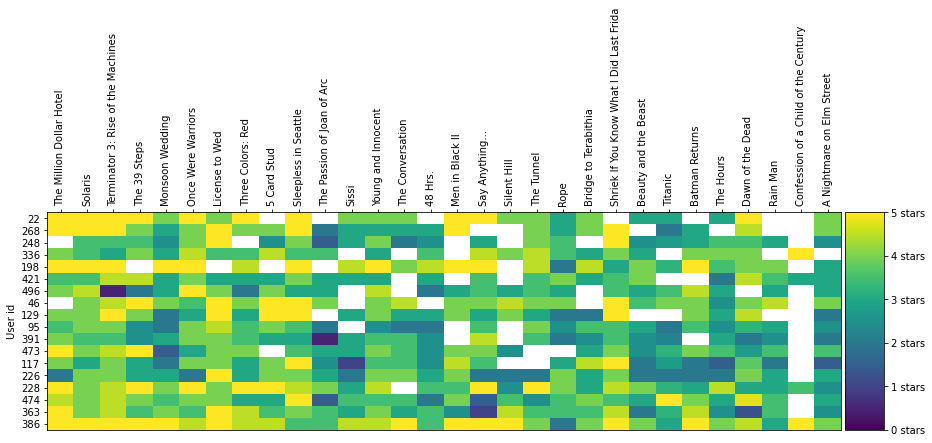

In [12]:
draw_movies_heatmap(most_rated_movies_users_selection)

In [20]:
# Pivot the dataset and choose the first 1000 movies
# Cannot run the following code
# error message：Unable to allocate 14.7 GiB for an array with shape (265917, 7409) and data type float64
user_movie_ratings = pd.pivot_table(ratings_title, index='userID', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)

KeyboardInterrupt: 

In [24]:
# Since the data is too big, we restrict it by choosing the 1000 mosted rated movies in first 5000 movies.
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings[1:5000], 1000)

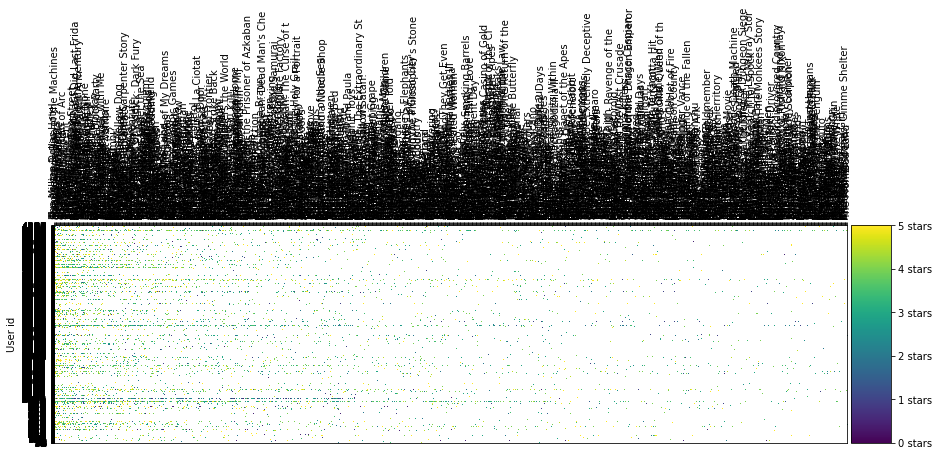

In [25]:
draw_movies_heatmap(most_rated_movies_1k)

In [26]:
sparse_ratings = csr_matrix(most_rated_movies_1k.astype(pd.SparseDtype("float", np.nan)).sparse.to_coo())

In [27]:
def draw_movie_clusters(clustered, max_users, max_movies):
    c=1
    for cluster_id in clustered.group.unique():
        # To improve visibility, we're showing at most max_users users and max_movies movies per cluster.
        # You can change these values to see more users & movies per cluster
        d = clustered[clustered.group == cluster_id].drop(['index', 'group'], axis=1)
        n_users_in_cluster = d.shape[0]
        
        d = sort_by_rating_density(d, max_movies, max_users)
        
        d = d.reindex(d.mean().sort_values(ascending=False).index, axis=1)
        d = d.reindex(d.count(axis=1).sort_values(ascending=False).index)
        d = d.iloc[:max_users, :max_movies]
        n_users_in_plot = d.shape[0]
        
        # We're only selecting to show clusters that have more than 9 users, otherwise, they're less interesting
        #if len(d) > 9:
        print('cluster # {}'.format(cluster_id))
        print('# of users in cluster: {}.'.format(n_users_in_cluster), '# of users in plot: {}'.format(n_users_in_plot))
        fig = plt.figure(figsize=(15,4))
        ax = plt.gca()

        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = d.columns.str[:40]

        ax.set_yticks(np.arange(d.shape[0]) , minor=False)
        ax.set_xticks(np.arange(d.shape[1]) , minor=False)

        ax.set_xticklabels(labels, minor=False)

        ax.get_yaxis().set_visible(False)

        # Heatmap
        heatmap = plt.imshow(d, vmin=0, vmax=5, aspect='auto')

        ax.set_xlabel('movies')
        ax.set_ylabel('User id')

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)

        # Color bar
        cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
        cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

        plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', labelbottom='off', labelleft='off') 
        #print('cluster # {} \n(Showing at most {} users and {} movies)'.format(cluster_id, max_users, max_movies))

        plt.show()


        # Let's only show 5 clusters
        # Remove the next three lines if you want to see all the clusters
        # Contribution welcomed: Pythonic way of achieving this
        # c = c+1
        # if c > 6:
        #    break

cluster # 0
# of users in cluster: 220. # of users in plot: 70


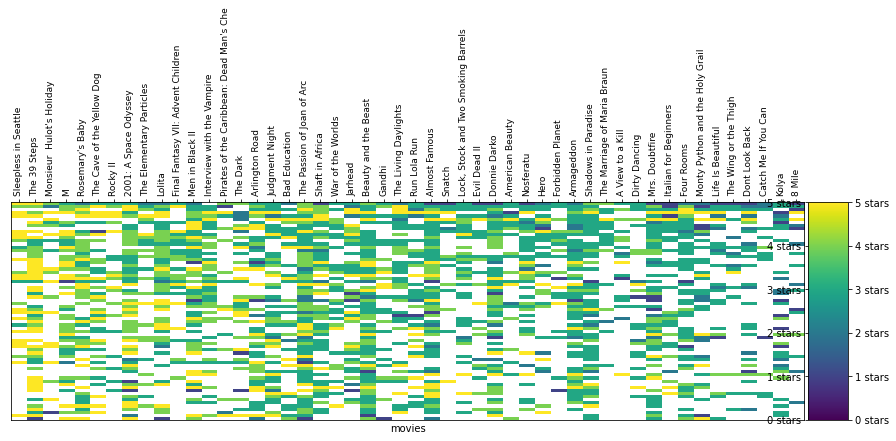

cluster # 5
# of users in cluster: 2503. # of users in plot: 70


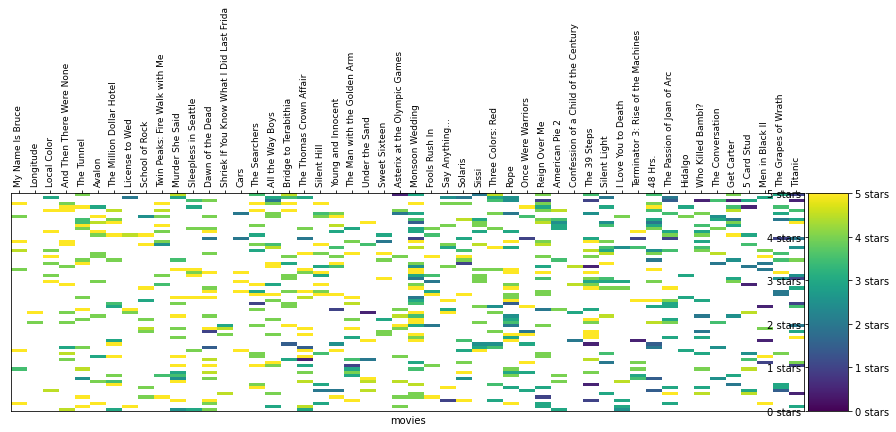

cluster # 12
# of users in cluster: 235. # of users in plot: 70


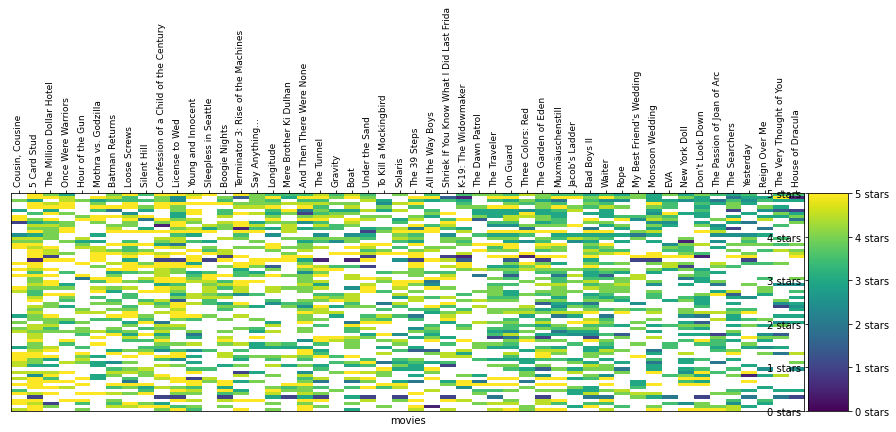

cluster # 3
# of users in cluster: 385. # of users in plot: 70


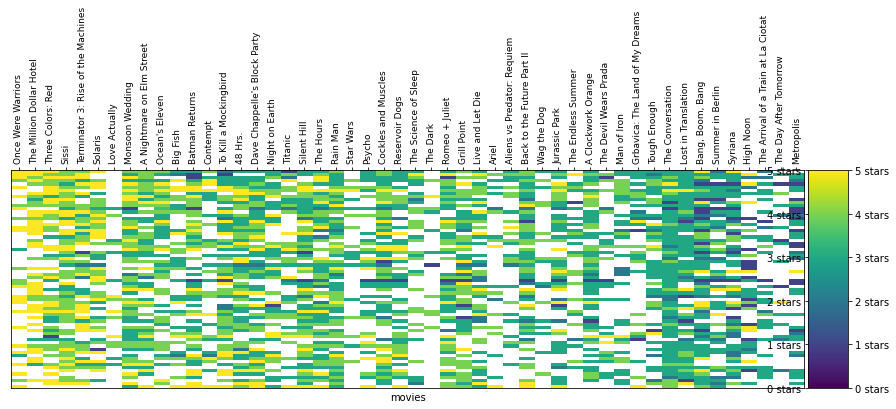

cluster # 4
# of users in cluster: 658. # of users in plot: 70


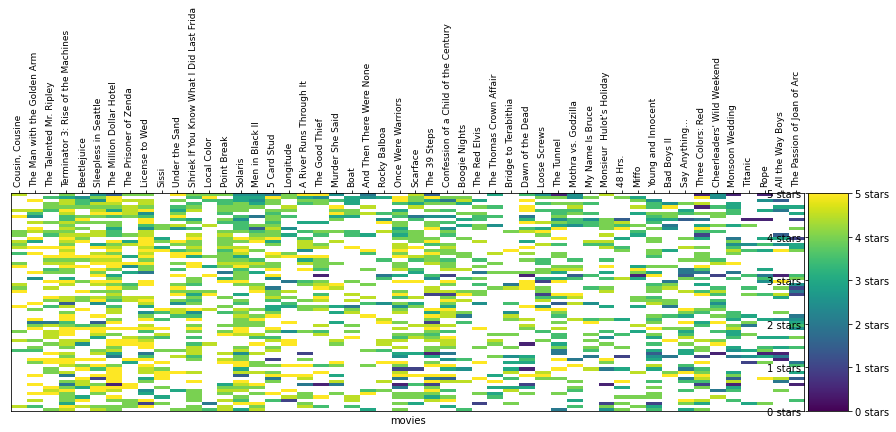

cluster # 10
# of users in cluster: 138. # of users in plot: 70


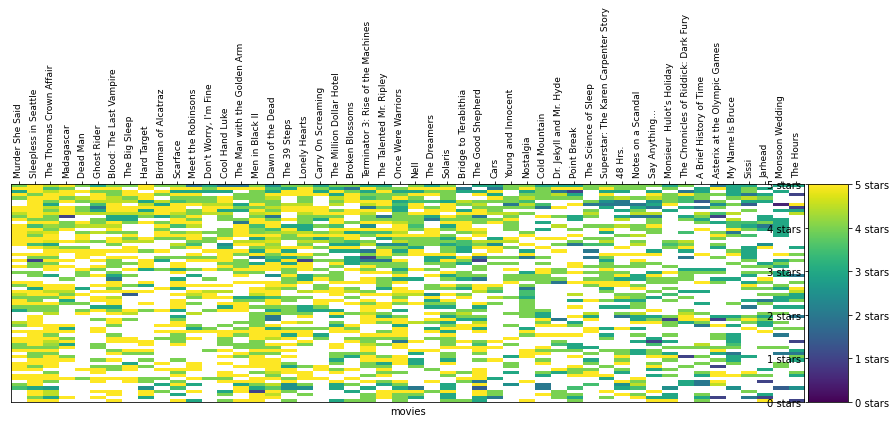

cluster # 11
# of users in cluster: 189. # of users in plot: 70


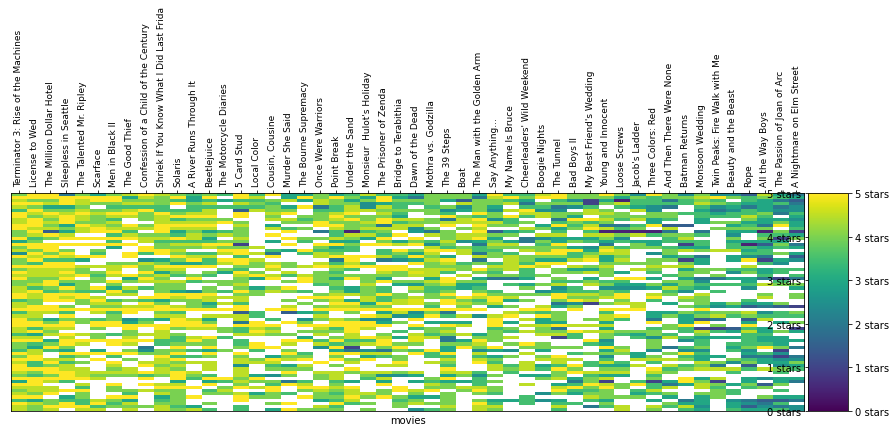

cluster # 2
# of users in cluster: 92. # of users in plot: 70


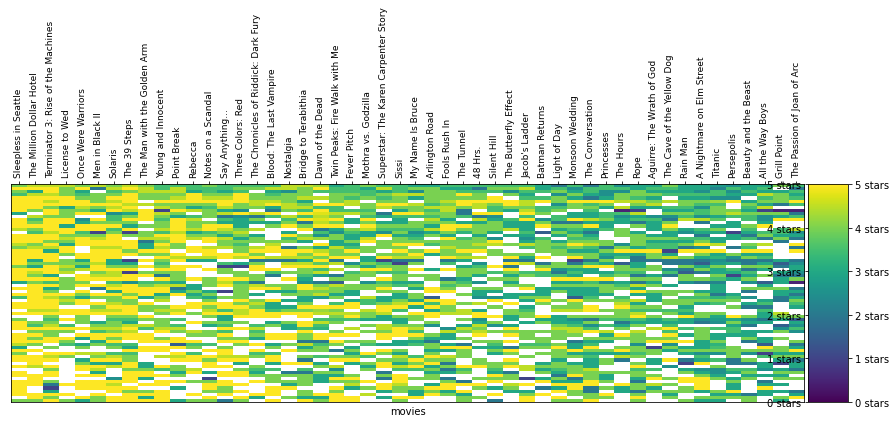

cluster # 1
# of users in cluster: 223. # of users in plot: 70


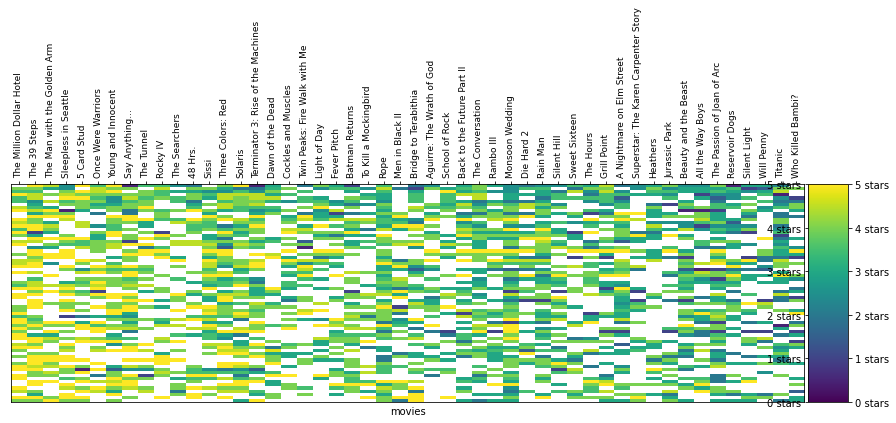

cluster # 9
# of users in cluster: 45. # of users in plot: 45


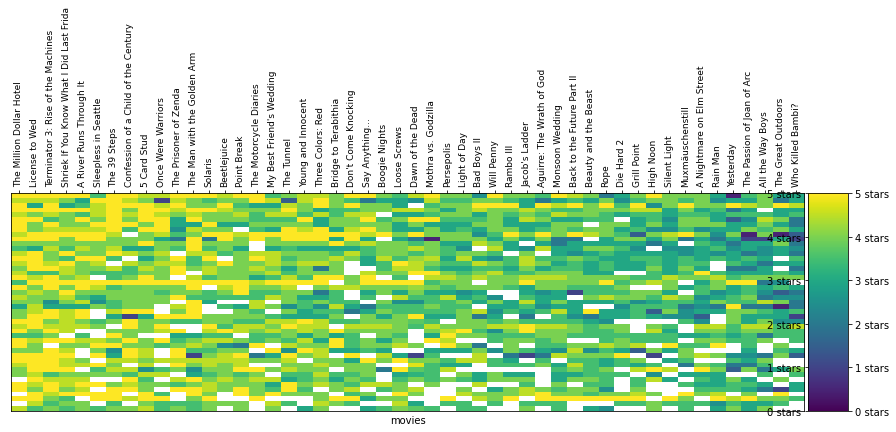

cluster # 8
# of users in cluster: 89. # of users in plot: 70


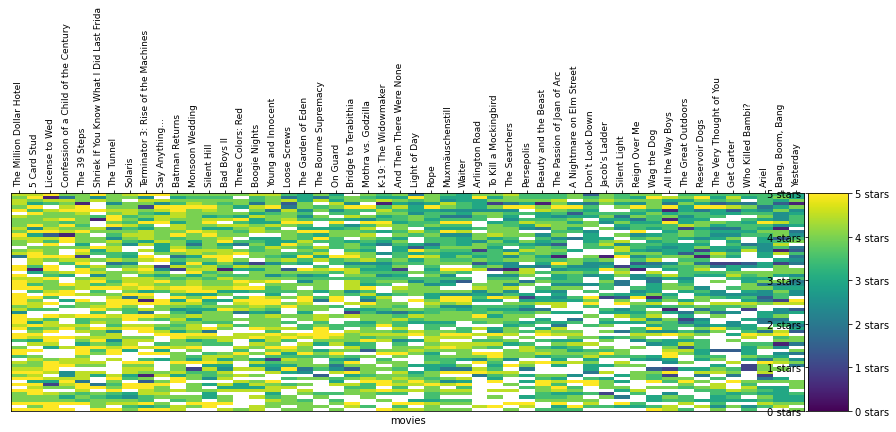

cluster # 7
# of users in cluster: 191. # of users in plot: 70


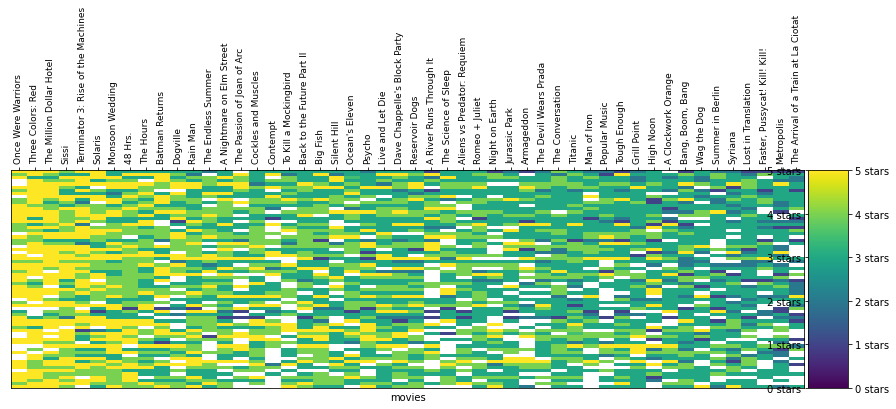

cluster # 13
# of users in cluster: 14. # of users in plot: 14


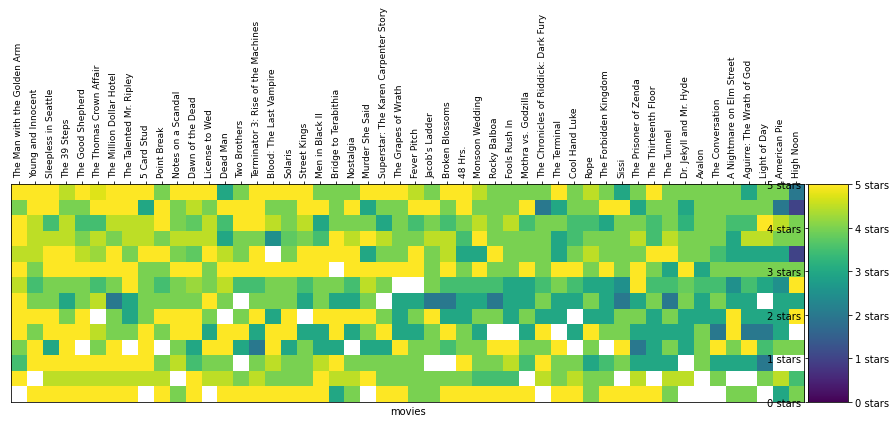

cluster # 14
# of users in cluster: 10. # of users in plot: 10


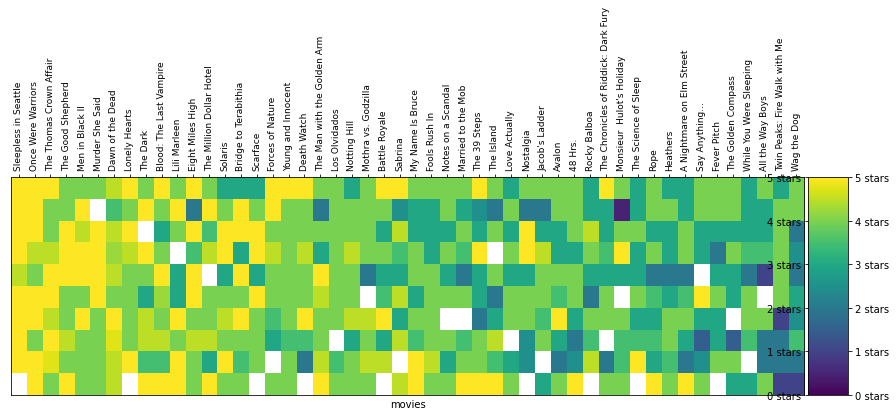

cluster # 6
# of users in cluster: 7. # of users in plot: 7


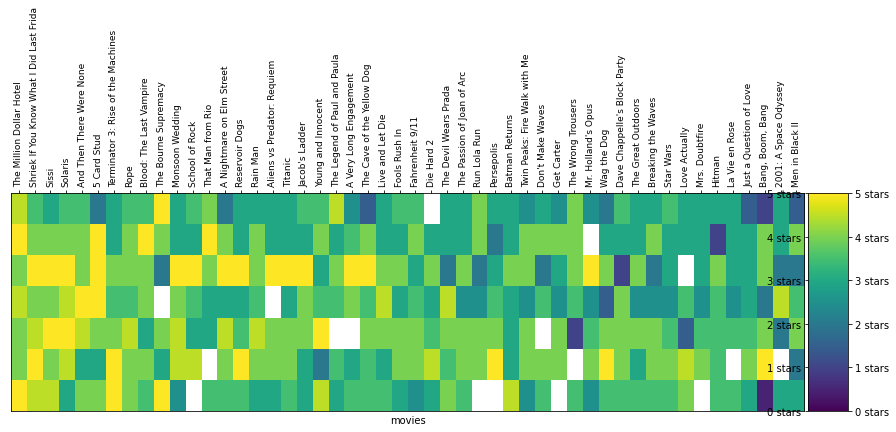

In [28]:
# 15 clusters
predictions = KMeans(n_clusters=15, algorithm='full').fit_predict(sparse_ratings)
# Select the mas number of users and movies heatmap cluster
max_users = 70
max_movies = 50
# Cluster and print some of them
clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
draw_movie_clusters(clustered, max_users, max_movies)

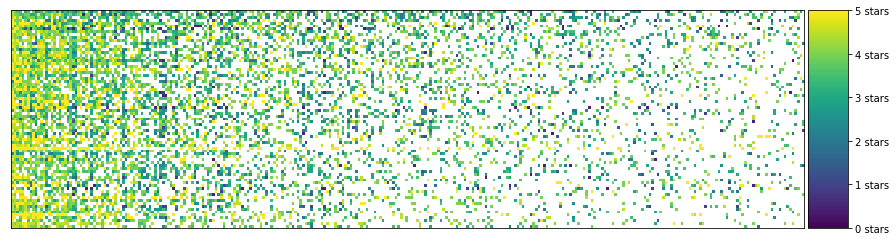

In [29]:
# Pick a cluster ID from the clusters above
cluster_number = 11
# Let's filter to only see the region of the dataset with the most number of values 
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)
# Sort and print the cluster
cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)

In [30]:
# Print the ratings
cluster.fillna('').head()

,Terminator 3: Rise of the Machines,License to Wed,Shriek If You Know What I Did Last Friday the Thirteenth,5 Card Stud,Solaris,The Million Dollar Hotel,Point Break,Young and Innocent,The 39 Steps,The Tunnel,...,"Amigo, Stay Away",Stitches,Dog Day Afternoon,We Own the Night,Jay and Silent Bob Strike Back,The Mourning Forest,Greed,Flags of Our Fathers,Leon: The Professional,Breaking the Waves
148,4.5,4,3.5,3.5,,3,3.5,,4,2,...,,,3,,,,4,,3,
27,4.5,4,4,3.5,3.5,4,4,3,3,3.5,...,,,,,,,,4.5,,
45,4.5,5,4,5,3,3.5,4,4,4,3,...,,,,,2.5,2,4,3.5,,
18,5,4,4,4,,4,3,,5,4,...,2,,3,,,,1,,,
150,5,5,4,5,5,5,5,4,4,5,...,,,,,,,,,,


In [31]:
# Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
movie_name = "Solaris"
cluster[movie_name].mean()

4.2384615384615385

In [32]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

Terminator 3: Rise of the Machines                          4.486301
License to Wed                                              4.534247
Shriek If You Know What I Did Last Friday the Thirteenth    4.230769
5 Card Stud                                                 4.114286
Solaris                                                     4.238462
The Million Dollar Hotel                                    4.394737
Point Break                                                 4.123077
Young and Innocent                                          3.727273
The 39 Steps                                                4.007937
The Tunnel                                                  3.681818
Sleepless in Seattle                                        4.400000
Beetlejuice                                                 4.118644
Under the Sand                                              4.158333
Monsoon Wedding                                             3.419355
Say Anything...                   

In [33]:
# Pick a user ID from the dataset
user_id = 27
# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]
# Which movies did they not rate? 
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]
# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]
# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

Human Nature              4.428571
Deep Blue Sea             4.333333
Ghost Rider               4.307692
Monsieur Batignole        4.285714
What's New Pussycat?      4.166667
Stranger Than Fiction     4.125000
Judgment Night            4.109375
Stitches                  4.100000
The Sixth Sense           4.045455
Secret Agent              4.035714
Hour of the Gun           3.964286
The Dreamers              3.961538
Princesses                3.944444
Star 80                   3.928571
Don Q Son of Zorro        3.916667
Leon: The Professional    3.900000
The Killing               3.875000
Felidae                   3.863636
Ken Park                  3.861111
Stand by Me               3.857143
Name: 0, dtype: float64